Carga el df

In [2]:
import pandas as pd
import pickle
import os

# Carga el DataFrame desde el archivo
# Directorio que contiene los archivos Pickle
directorio = "bloquesData" 

# Lista para almacenar los DataFrames
dataframes = []

# Enumera los archivos en el directorio y ordena alfabéticamente
archivos = sorted([archivo for archivo in os.listdir(directorio) if archivo.startswith("progreso_iter_") and archivo.endswith(".pkl")])

# Cargar los DataFrames desde los archivos Pickle
for archivo in archivos:
    ruta_completa = os.path.join(directorio, archivo)
    with open(ruta_completa, "rb") as file:
        df = pickle.load(file)
        dataframes.append(df)

# Concatenar los DataFrames en uno solo
merged_data = pd.concat(dataframes, ignore_index=True)

print("Tamaño del df parcial: ",len(merged_data))

merged_data.head()



Tamaño del df parcial:  3577144


,user_id,item_id,playtime_forever,genres,publisher,title,recommend
0,76561198045133986,105600,4311,Action,Re-Logic,Terraria,NaN
1,76561198045133986,105600,4311,Adventure,Re-Logic,Terraria,NaN
2,76561198045133986,105600,4311,Indie,Re-Logic,Terraria,NaN
3,76561198045133986,105600,4311,RPG,Re-Logic,Terraria,NaN
4,76561198045133986,65800,7501,Action,Trendy Entertainment,Dungeon Defenders,NaN


### Analisis de indice de relación
variables categoricas (Coeficiente de Cramér)

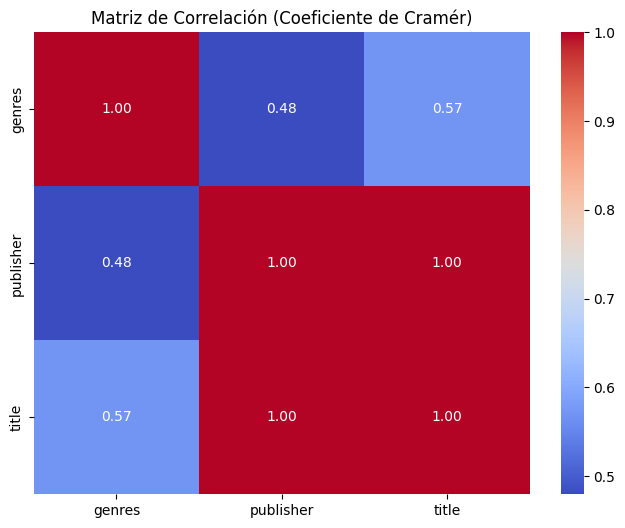

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

categorias = ['genres', 'publisher', 'title']

# Calcula el coeficiente de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

correlation_matrix = pd.DataFrame(index=categorias, columns=categorias)
for i in categorias:
    for j in categorias:
        correlation_matrix.loc[i, j] = cramers_v(merged_data[i], merged_data[j])

# Visualiza la matriz de correlación en un mapa de calor
plt.figure(figsize=(8, 6))
# Convierte los valores de la matriz de correlación a tipo float
correlation_matrix = correlation_matrix.astype(float)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación (Coeficiente de Cramér)")
plt.show()



Como existe una relación entre publisher y titulo, voy a eliminar title, para la correlación

### Creo el df Indice de los juegos

In [36]:
catalogo_juegos = merged_data[['item_id', 'title']].copy()
#catalogo_juegos = catalogo_juegos.drop_duplicates(subset=['item_id'])
catalogo_juegos['title'] = catalogo_juegos['title'].str.upper()

total = len(catalogo_juegos)
print("Cantidad de juegos: ",total)

# Guardar el DataFrame en un archivo CSV
total = len(catalogo_juegos)
print("Total de registros: ",total)
catalogo_juegos.to_csv('dataRender//catalogo_juegos.csv', index=False) 

print("tipo de dato: ",type(catalogo_juegos))
display(catalogo_juegos.head(8))

C:\Users\adeal\AppData\Local\Temp\ipykernel_20384\3699403061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalogo_juegos['title'] = catalogo_juegos['title'].str.upper()


Cantidad de juegos:  3577144
Total de registros:  3577144
tipo de dato:  <class 'pandas.core.frame.DataFrame'>


,item_id,title
0,105600,TERRARIA
1,105600,TERRARIA
2,105600,TERRARIA
3,105600,TERRARIA
4,65800,DUNGEON DEFENDERS
5,65800,DUNGEON DEFENDERS
6,65800,DUNGEON DEFENDERS
7,65800,DUNGEON DEFENDERS


In [37]:
# Encuentra valores nulos en 'mi_columna'
valores_nulos = catalogo_juegos['title'].isnull()
cantidad_valores_nulos = valores_nulos.sum()

# Imprime la cantidad de valores nulos
print(f"Cantidad de valores nulos en title: {cantidad_valores_nulos}")

Cantidad de valores nulos en title: 0


### Construye la matriz de similitud
Caracteristicas analizadas:
-   genres
-   publisher


In [38]:
from sklearn.metrics.pairwise import cosine_similarity

# Elegir las características para el cálculo de similitud
features = merged_data[["item_id", "genres", "publisher"]]

# Pivotea los datos para obtener una matriz de características por juego
pivot_data = features.pivot_table(index="item_id", columns=["genres", "publisher"], aggfunc=lambda x: 1, fill_value=0)

# Calcula la matriz de similitud del coseno
similarities = cosine_similarity(pivot_data)

# Convierte la matriz de similitud en un DataFrame para un fácil acceso
similarity_matrix = pd.DataFrame(similarities, index=pivot_data.index, columns=pivot_data.index)

similarity_matrix.head()


item_id,10,20,30,40,50,60,70,80,130,220,...,526460,526790,527340,527440,527510,527520,527810,527900,528660,530720
item_id,,,,,,,,,,,,,,,,,,,,,
10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Guardar el DataFrame en un archivo CSV
total = len(similarity_matrix)
print("Total de registros: ",total)
similarity_matrix.to_csv('dataRender//matriz.csv', index=False) 

Total de registros:  8177


### Funcion de recomendacion de juegos

In [41]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(game, n=5):
    try:
        input_game = game.upper()
        
        # Carga los df: matriz y catalogo_juegos
        similarity_matrix = pd.read_csv('dataRender/matriz.csv')
        #game_data = pd.read_csv('dataRender/catalogo_juegos.csv')
        game_data = merged_data.copy()

        # Encuentra el ID del juego de entrada
        game_entry = game_data[game_data["title"].str.upper() == input_game]
        
        if not game_entry.empty:
            input_game_id = game_entry["item_id"].iloc[0]

            # Obtiene la fila de similitud para el juego de entrada
            input_game_similarity = similarity_matrix.iloc[input_game_id]

            # Ordena los juegos por similitud en orden descendente
            recommended_games = game_data.iloc[input_game_similarity.argsort()[::-1]]

            # Elimina el juego de entrada de las recomendaciones
            recommended_games = recommended_games[recommended_games["item_id"] != input_game_id]

            # Selecciona las primeras n recomendaciones
            top_n_recommendations = recommended_games.head(n)
            
            return top_n_recommendations
        else:
            print(f"El juego '{input_game}' no se encuentra en la base de datos.")
            return None
    except Exception as e:
        print(f"Ocurrió un error: {str(e)}")
        return None

# Ejemplo de uso
input_game = "Dungeon Defenders"  # Ingresa el nombre del juego
recommendations = get_recommendations(input_game)

if recommendations is not None:
    print(recommendations)

# recommendations contendrá las 5 recomendaciones principales basadas en similitud


Ocurrió un error: single positional indexer is out-of-bounds
